<a href="https://colab.research.google.com/github/vjmiyagi/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
# TODO - code!

In [3]:
#@title This cell contains imports
# imports
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#@title This cell contains imports
# imports
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rc

In [0]:
#@title This cell contains imports
# imports
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rc

In [0]:
#@title This Cell Defines Function for Bayes Theorem
def bayes(p_a, tpr, fpr, tests):
    p_a_given_b =p_a
    for test in range(0, tests):
        p_a = p_a_given_b  # prior belief
        p_not_a = 1 -p_a  # complement of the prior belief
        p_a_given_b  = (tpr*p_a)/((tpr*p_a) + (fpr*p_not_a))
    return p_a_given_b 

In [7]:
#@title Bayes Theorem Calcultor { run: "auto" }


p_a = 0.001 #@param {type:"number"}
fpr = 0.08 #@param {type:"number"}
tpr = .1 #@param {type:"number"}
tests = 6 #@param {type:"slider", min:1, max:10, step:1} 

# try it out

result = bayes(p_a, tpr, fpr, tests)



print('P(A|B) = %.3f%%' % (result * 100))

P(A|B) = 0.380%


What is the probability that a person is drunk after one positive breathalyzer test?


In [8]:
result = bayes(p_a, tpr, fpr, 1)

print('P(A|B) = %.3f%%' % (result * 100))

P(A|B) = 0.125%


What is the probability that a person is drunk after two positive breathalyzer tests?

In [9]:
result = bayes(p_a, tpr, fpr, 2)

print('P(A|B) = %.3f%%' % (result * 100))

P(A|B) = 0.156%


How many positive breathalyzer test are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

In [10]:
result = bayes(p_a, tpr, fpr, 4)


print('It takes 4 tests                                                       to reach a probability of greater than 95%')
print('P(A|B) = %.3f%%' % (result * 100))

It takes 4 tests                                                       to reach a probability of greater than 95%
P(A|B) = 0.244%


# Explore scipy.stats.bayes_mvs

In [11]:
#@title This cell gets data with bang command
# Get the data

# wget
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data --no-check-certificate

--2020-04-15 04:02:01--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-04-15 04:02:02 (286 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [12]:
#@title This cell makes the dataframe and prints head
# Make DataFrame
cols = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
house_df = pd.read_csv('house-votes-84.data',header=None,
                    names=cols)
house_df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [13]:
#@title This cell cleans data using 0 for ?
house_df = house_df.replace({'y':1, 'n':0, '?':0})
house_df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0
2,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0
3,democrat,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1


In [14]:
#@title This cell makes two dataframes for the two parties
dem_df = house_df[house_df['party']=='democrat']
print('dem',dem_df.shape)
rep_df = house_df[house_df['party']=='republican']
print('rep',rep_df.shape)

dem (267, 17)
rep (168, 17)


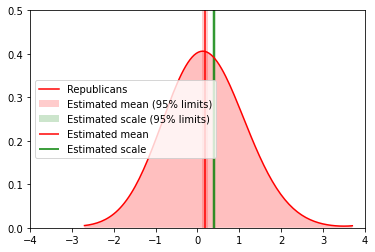

In [89]:
#@title Use this cell to select a bill to analyze. { run: "auto" }
bill = "handicapped-infants" #@param ['aid-to-contras', 'anti-satellite-ban', 'budget', 'crime', 'duty-free', 'education', 'el-salvador-aid', 'handicapped-infants', 'immigration', 'mx-missile', 'physician-fee-freeze', 'religious-groups', 'right-to-sue', 'south-africa', 'synfuels', 'water-project']
votes = "Republicans" #@param ["House of Representatives", "Democrats", "Republicans"]

bill.title()

if votes == 'House of Representatives':
    df = house_df[bill]
    grph_label = 'House'
    grph_color = 'g'
if votes =='Democrats':
    df = dem_df[bill]
    grph_label = 'Democrats'
    grph_color = 'b'
if votes == 'Republicans':
    df = rep_df[bill]
    grph_label = 'Republicans'
    grph_color = 'r'

res_mean, res_var, res_std = stats.bayes_mvs(df, alpha=0.99)

fig = plt.figure()
ax = fig.add_subplot()

sns.kdeplot(df,
            bw='.9', shade=True,
            label=grph_label, color = grph_color, ax=ax);


ax.vlines(res_mean.statistic, 0, 0.5, colors='r', label='Estimated mean')
ax.axvspan(res_mean.minmax[0],res_mean.minmax[1], facecolor='r',
           alpha=0.2, label=r'Estimated mean (95% limits)')
ax.vlines(res_std.statistic, 0, 0.5, colors='g', label='Estimated scale')
ax.axvspan(res_std.minmax[0],res_std.minmax[1], facecolor='g', alpha=0.2,
           label=r'Estimated scale (95% limits)')

ax.legend(fontsize=10)
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.5])
plt.show()

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!